In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [58]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

In [3]:
using ChainRulesCore: ignore_derivatives

In [4]:
using Base: @kwdef

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [14]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [15]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [17]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [18]:
q |> size

(20, 13, 21, 99991)

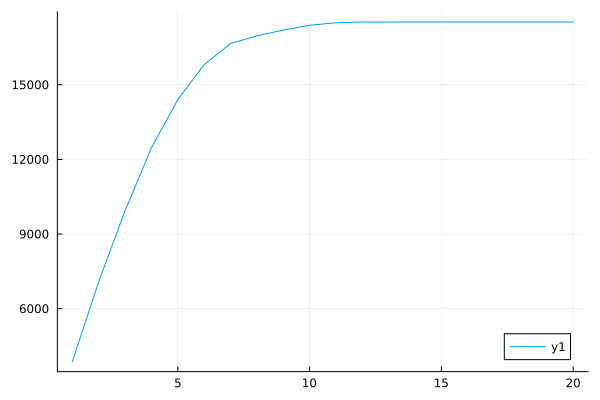

In [19]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

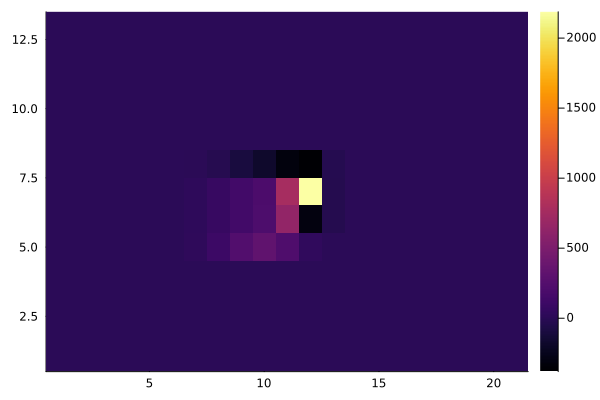

In [20]:
heatmap(q[1,:,:,128])

In [21]:
ylocal |> size

(99991,)

In [22]:
pt |> size

(99991,)

In [23]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [24]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [25]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [26]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [27]:
x |> size

(20, 13, 21, 128)

In [28]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [30]:
function process_inputs(x::AbstractArray, x_tms::AbstractVector, y_local::AbstractArray, spk_args::SpikingArgs)
    v_fn = t -> sum(scale_charge(interpolate_2D(t, x_tms, x)), dims=2)[:,1,:]
    y_fn = t -> ylocal_to_current(t, y_local, spk_args)

    x_fn = t -> cat(v_fn(t), reshape(y_fn(t), (1,:)), dims=1)
    return x_fn
end

process_inputs (generic function with 1 method)

In [31]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [33]:
x_tms = range(start=0.0, stop=1.0, length=size(x, 1)) |> collect

20-element Vector{Float64}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [34]:
i_fn = process_inputs(x, x_tms, xl, sa)

#40 (generic function with 1 method)

In [35]:
function sample_current(t, x, i_fn)
    i = sum(i_fn(t), dims=(2))
    i = i[:,1,:]

end

sample_current (generic function with 1 method)

In [36]:
sample_current(0.5, x, i_fn)

14×1 Matrix{Float64}:
   0.0
   0.9312
  12.72694
  83.212
 240.36753999999993
 304.9427600000001
 254.99722000000003
  75.04914
  10.44664
  -0.008279999999999994
   0.0
   0.0
   0.0
  21.045959887366465

In [38]:
ode_fn = Chain(BatchNorm(n_in),
                    x -> tanh.(x),
                    Dense(n_in => 128))

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction(#44),
    layer_3 = Dense(14 => 128),         # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [39]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
x -> complex_to_angle(Array(x)[:,:,end]),
PhasorDenseF32(128 => 3))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction(#44),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction(#46),
    layer_3 = PhasorDenseF32((3, 128)),  # 390 parameters
)         # Total: 2_338 parameters,
          #        plus 29 states.

In [40]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()),

In [42]:
y_naive, _ = ode_model(i_fn, ps, st);

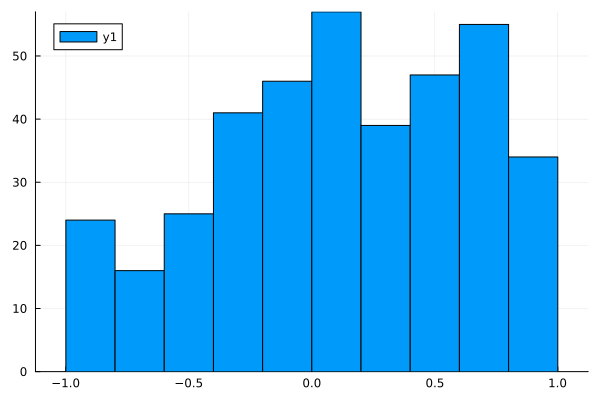

In [43]:
histogram(y_naive |> vec)

In [49]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [44]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [45]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [56]:
function loss(x, x_tms, xl, y, model, ps, st, threshold, spk_args::SpikingArgs=SpikingArgs())
    drive_fn = process_inputs(x, x_tms, xl, spk_args)
    y_pred, st = model(drive_fn, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 2 methods)

In [59]:
loss(x, x_tms, xl, y, ode_model, psa, st, 0.2)

(0.7823017057233769, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [61]:
(loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, ode_model, p, st, 0.2), psa)

(val = (0.7823016784003473, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())), grad = ((layer_1 = (layer_1 = (scale = Float32[0.011527562, -0.009585654, 9.863274f-5, -0.021618558, 0.065924674, 0.068935424, -0.014281816, -0.019750223, 5.548827f-5, -0.032373838, -0.00780892, 0.0, 0.0, -0.0755052], bias = Float32[0.094231755, 0.043128546, -0.059831996, 0.03950188, -0.033843733, -0.117351316, 0.06703642, 0.032647885, 0.09836483, 0.06474271, 0.09151063, -0.10884143, -0.26623213, -0.055274423]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.0022527648 -0.0022420066 … 0.0 -0.023072165; -0.0040059933 0.00073116744 … 0.0 -0.059380375; … ; 0.007807198 0.013398728 … 0.0 0.09658991; 0.0035845097 -0.005889355 … 0.0

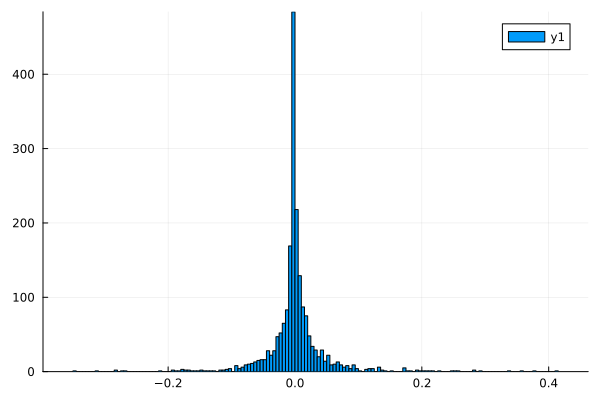

In [68]:
histogram(gs[1].layer_1 |> vec)

In [69]:
function train(model, ps, st, train_loader, x_tms, threshold::Real = 0.2; id::Int=1, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
        println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [72]:
loss_history, pst, stt = train(ode_model, ps, st, train_loader, x_tms, 0.2, epochs = 1)

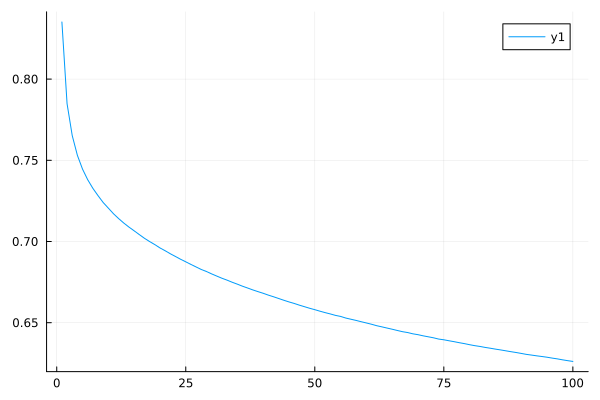

In [ ]:
plot(loss_history)

In [ ]:
#load params

In [51]:
pst = pst2

(layer_1 = (scale = Float32[1.4697739, 1.1580201, 1.0198406, 1.0529824, 1.3306414, 0.99830335, 1.1047245, 0.45129508, 0.61435616, 0.5544806  …  0.76070774, 0.45025367, 0.44715136, 0.68416, 0.38878638, 0.77557844, 0.4225336, 0.82894355, 0.6843885, 2.1894317], bias = Float32[0.0077468446, 0.10698929, -0.050629485, 0.05460481, 0.13481493, 0.10446353, -0.03299141, -0.026561724, 0.15873784, 0.14660995  …  -0.050419666, 0.010568192, 0.016822055, 0.15912247, -0.023819111, 0.13997678, -0.10000029, 0.1648359, 0.15047394, 0.028402999]), layer_2 = (weight = Float32[-0.05932214 -0.41674483 … -0.18414524 0.0541863; -0.19706695 0.05320552 … -0.07384117 -0.38292387; … ; -0.119156264 0.045651462 … 0.17305084 -0.08249801; -0.43498686 -0.23503207 … -0.120095365 -0.0051032878], bias = Float32[0.013542293; -0.27018693; … ; 0.21054368; -0.111689106;;]), layer_3 = (weight = Float32[0.15412416 0.101925105 … -0.016297584 0.009354383; -0.17179129 -0.1216197 … 0.13791005 -0.034549084; 0.19139546 -0.22807682 … -

In [52]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [53]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.49975631991829567, (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [54]:
loss_history[end]

0.6261509859407995

In [56]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([-2.519516804982199 -1.1995193007577 … -4.224558226858901 -2.433261296710905; -0.10455519180957262 0.3949108881456629 … -2.8674384266207262 0.05839572546381888; -1.9044175503851382 0.8860764231493787 … 1.3112104513442362 0.8442173852517455], (layer_1 = (running_mean = [4.511204171872861, 8.65471737374742, 15.768950652079411, 25.47577162264427, 37.14460779301397, 72.70160731963594, 80.49836605960213, 80.55718987622959, 80.71183251347792, 80.80832442370571  …  14.284271244364543, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 0.2094285897770764], running_var = [13660.373003240746, 30128.09425443063, 57648.062831771786, 135759.6512328185, 260384.88539216772, 782699.2420293362, 999334.5624244238, 1.0023288976299643e6, 1.0031768876253767e6, 1.0036215950555098e6  …  187597.2068313208, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827, 1875

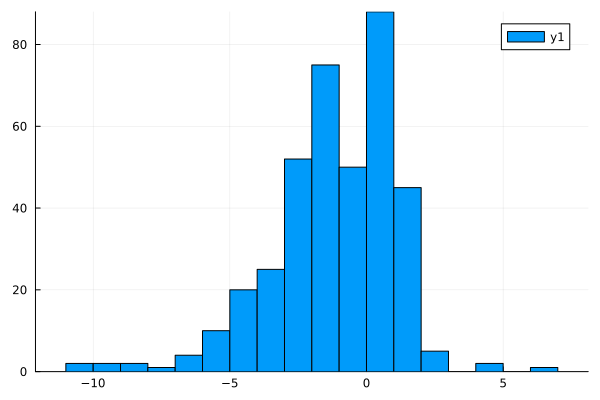

In [58]:
histogram(yt |> vec)

# Calculate the Test Loss

In [59]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [63]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [64]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([-8.951957053679283 -3.6941626634602707 … -3.4857271452095633 -3.470447021067624; -8.647090095462493 -5.304786819189028 … -0.5439040669813904 -0.8142507597652024; -2.6063647653432254 -0.7983498236050062 … -2.110489934836995 -1.4780349212831423], (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.9

In [65]:
accuracy(xts, xlts, yts, model, pst, sttf, 0.2)

91

In [66]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [67]:
using LinearAlgebra: diag

In [70]:
roc = tpr_fpr(yth, yts)

([0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625  …  0.9765625, 0.9765625, 0.984375, 0.984375, 0.984375, 0.984375, 0.984375, 0.9921875, 0.9921875, 0.9921875], [0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0078125  …  0.8515625, 0.859375, 0.859375, 0.859375, 0.87109375, 0.875, 0.8828125, 0.88671875, 0.8984375, 0.8984375])

In [73]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0078125
│     0.0078125
│     0.0078125
│     0.0078125
│     ⋮
│     0.8828125
│     0.88671875
│     0.8984375
│     0.8984375
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 0.015625
 ⋮
 0.9765625
 0.9765625
 0.9765625
 0.984375
 0.984375
 0.984375
 0.984375
 0.984375
 0.9921875
 0.9921875
 0.9921875
 1.0

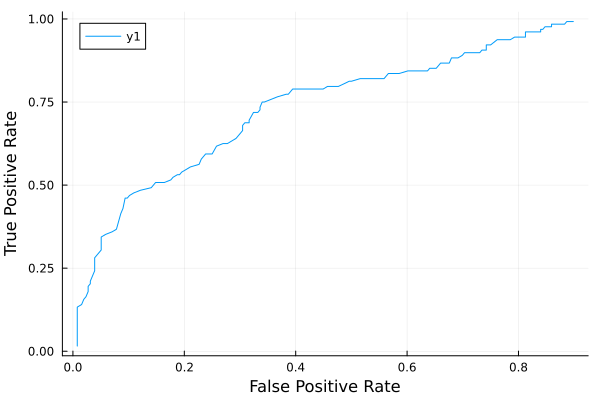

In [74]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

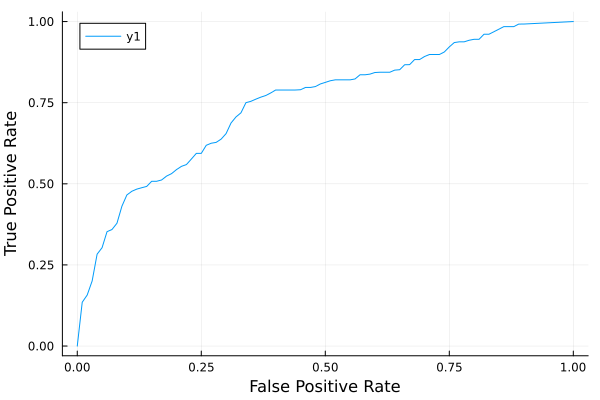

In [76]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [78]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.749191262006996, 1.0611857134993838e-8)